In [1]:
#Use Pyart35 env

<center><h1>Proccessing data and scattering</h1>
*Scott Collis, Jonathan Helmus, Kirk North, Tim Lang, Kai Mühlbauer*
</center>


In [50]:
import pyart
import netCDF4
import numpy as np
import platform
from matplotlib import pyplot as plt
from glob import glob
import os
from datetime import datetime
from scipy import interpolate
import fnmatch
import matplotlib.dates as mdates
from pytmatrix.tmatrix import TMatrix, Scatterer
from pytmatrix.tmatrix_psd import TMatrixPSD, GammaPSD
from pytmatrix import orientation, radar, tmatrix_aux, refractive
import pickle
from pytmatrix.psd import PSDIntegrator, GammaPSD
from matplotlib.colors import LogNorm

%matplotlib inline

In [3]:
#determine system

In [4]:
my_system = platform.system()
if my_system == 'Darwin':
    top = '/data/sample_sapr_data/sgpstage/sur/'
    s_dir = '/data/sample_sapr_data/sgpstage/interp_sonde/'
    d_dir = '/data/agu2016/dis/'
    odir_r = '/data/agu2016/radars/'
    odir_s = '/data/agu2016/stats/'
    odir_i = '/data/agu2016/images/'
elif my_system == 'Linux':
    top = '/lcrc/group/earthscience/radar/sgpstage/sur/'
    s_dir = '/lcrc/group/earthscience/radar/sgpstage/interp_sonde/'
    odir_r = '/lcrc/group/earthscience/radar/agu2016/radars/'
    odir_s = '/lcrc/group/earthscience/radar/agu2016/stats/'
    odir_i = '/lcrc/group/earthscience/radar/agu2016/images/'


In [5]:
#index all distrometer files

def get_file_tree(start_dir, pattern):
    """
    Make a list of all files matching pattern
    above start_dir

    Parameters
    ----------
    start_dir : string
        base_directory

    pattern : string
        pattern to match. Use * for wildcard

    Returns
    -------
    files : list
        list of strings
    """

    files = []

    for dir, _, _ in os.walk(start_dir):
        files.extend(glob(os.path.join(dir, pattern)))
    return files

def match_distro_file(distro_date, dis_file_list):
    #sgpvdisC1.b1.20110623.000000.cdf
    pattern = datetime.strftime(distro_date,
                        '*sgpvdisC1.b1.%Y%m%d.*')
    dis_name = fnmatch.filter(dis_file_list, pattern)[0]
    return dis_name

def masked_conv(string, bad_val = -9999.):
    try:
        out = float(string)
    except:
        out = bad_val
    
    return out

def read_dis(dfile):
    fh = open(dfile)
    line = fh.readline()
    fh.close()
    return line

# For testing variable aspect ratio
def drop_ar(D_eq):
    if D_eq < 0.7:
        return 1.0;
    elif D_eq < 1.5:
        return 1.173 - 0.5165*D_eq + 0.4698*D_eq**2 - 0.1317*D_eq**3 - \
            8.5e-3*D_eq**4
    else:
        return 1.065 - 6.25e-2*D_eq - 3.99e-3*D_eq**2 + 7.66e-4*D_eq**3 - \
            4.095e-5*D_eq**4 

def scatter_off_2dvd(d_diameters, d_densities):
    mypds = interpolate.interp1d(d_diameters,d_densities, bounds_error=False, fill_value=0.0)
    tm = TMatrixPSD(wavelength=tmatrix_aux.wl_C, m=refractive.m_w_10C[tmatrix_aux.wl_C])
    tm.psd_eps_func = lambda D: 1.0/drop_ar(D)
    tm.D_max = 10.0
    tm.or_pdf = orientation.gaussian_pdf(20.0)
    tm.orient = orientation.orient_averaged_fixed
    tm.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
    tm.init_scatter_table()
    tm.psd = mypds#GammaPSD(D0=D0[i], Nw=Nw[j], mu=4)
    zdr=radar.Zdr(tm)
    z=radar.refl(tm)
    tm.set_geometry(tmatrix_aux.geom_horiz_forw)
    kdp=radar.Kdp(tm)
    A=radar.Ai(tm)
    return z,zdr,kdp,A

def scatter_off_2dvd_updated(d_diameters, d_densities):
    mypds = interpolate.interp1d(d_diameters,d_densities, bounds_error=False, fill_value=0.0)
    scatterer = Scatterer(wavelength=tmatrix_aux.wl_C, m=refractive.m_w_10C[tmatrix_aux.wl_C])
    #tm = TMatrixPSD(wavelength=tmatrix_aux.wl_C, m=refractive.m_w_10C[tmatrix_aux.wl_C])
    scatterer.psd_integrator = PSDIntegrator()
    scatterer.psd_integrator.axis_ratio_func = lambda D: 1.0/drop_ar(D)
    scatterer.psd_integrator.D_max = 10.0
    #tm.psd_eps_func = lambda D: 1.0/drop_ar(D)
    #tm.D_max = 10.0
    scatterer.psd_integrator.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
    scatterer.or_pdf = orientation.gaussian_pdf(20.0)
    scatterer.orient = orientation.orient_averaged_fixed
    scatterer.psd_integrator.init_scatter_table(scatterer)
    scatterer.psd = mypds#GammaPSD(D0=2.0, Nw=1e3, mu=4)
    radar.refl(scatterer)
    #tm.or_pdf = orientation.gaussian_pdf(20.0)
    #tm.orient = orientation.orient_averaged_fixed
    #tm.geometries = (tmatrix_aux.geom_horiz_back, tmatrix_aux.geom_horiz_forw)
    #tm.init_scatter_table()
    #tm.psd = mypds#GammaPSD(D0=D0[i], Nw=Nw[j], mu=4)
    zdr=radar.Zdr(scatterer)
    z=radar.refl(scatterer)
    scatterer.set_geometry(tmatrix_aux.geom_horiz_forw)
    kdp=radar.Kdp(scatterer)
    A=radar.Ai(scatterer)
    return z,zdr,kdp,A


In [112]:
all_rd_files = get_file_tree(odir_s, 'csapr_distro*')
all_rd_files.sort()
form = 'csapr_distro_%Y%m%d%H%M%S.txt'
radar_dis_date_list = [datetime.strptime(this_date.split('/')[-1], form) for this_date in all_rd_files]
all_lines = [read_dis(tfile) for tfile in all_rd_files]

ad_form = '%Y%m%d%H%M%S'
actual_dates = np.array([datetime.strptime(this_line.split()[0], ad_form) for this_line in all_lines])
distrometric_history = {}
for i in [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34, 36,38, 40, 42,44]:
    print(i, all_lines[10].split()[i-1])
    this_key = all_lines[10].split()[i-1]
    these_values = np.ma.masked_equal(\
                                      np.array([masked_conv(this_line.split()[i])\
                                      for this_line in all_lines]), -9999.0)
    distrometric_history.update({this_key : these_values})

distrometric_history.update({'radar_start':radar_dis_date_list,
                            'overpass_time':actual_dates})
print(len(actual_dates))

2 cross_correlation_ratio
4 height
6 gate_id
8 reflectivity
10 specific_differential_phase
12 corrected_specific_diff_phase
14 differential_phase
16 normalized_coherent_power
18 spectrum_width
20 unfolded_differential_phase
22 maesaka_forward_specific_diff_phase
24 bringi_specific_diff_phase
26 sounding_temperature
28 bringi_differential_phase
30 bringi_specific_diff_phase_sd
32 velocity_texture
34 maesaka_differential_phase
36 maesaka__reverse_specific_diff_phase
38 SNR
40 velocity
42 corrected_differential_phase
44 differential_reflectivity
2208


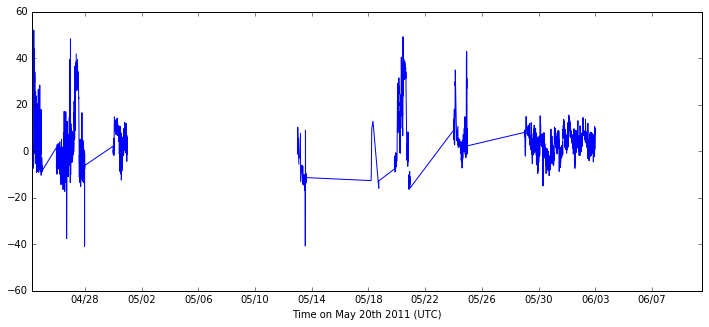

In [113]:
time1=mdates.datestr2num('20110424 0700')
time2=mdates.datestr2num('20110610 1210')

hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 4)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[12,5])
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['reflectivity'])
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')



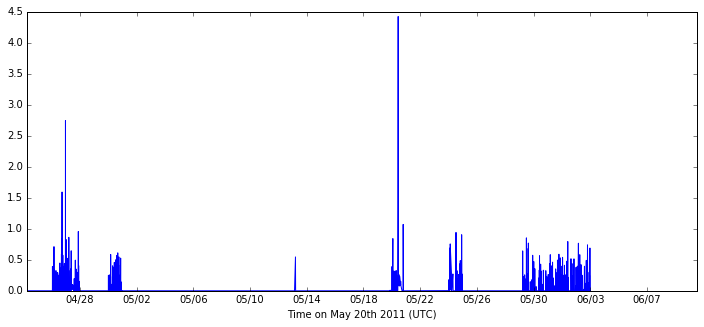

In [77]:
time1=mdates.datestr2num('20110424 0700')
time2=mdates.datestr2num('20110610 1210')

hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 4)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[12,5])
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['corrected_specific_diff_phase'])
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')



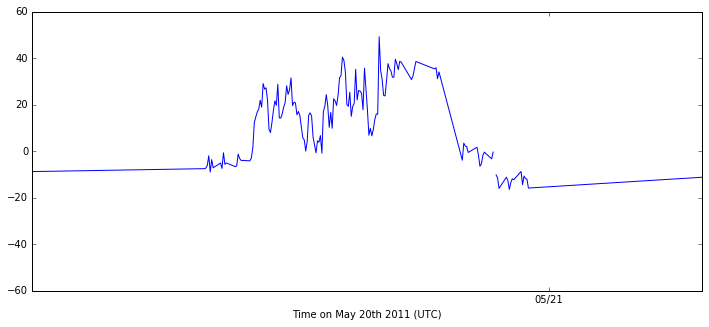

In [9]:
time1=mdates.datestr2num('20110519 0700')
time2=mdates.datestr2num('20110521 1210')

hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 4)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[12,5])
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['reflectivity'])
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')



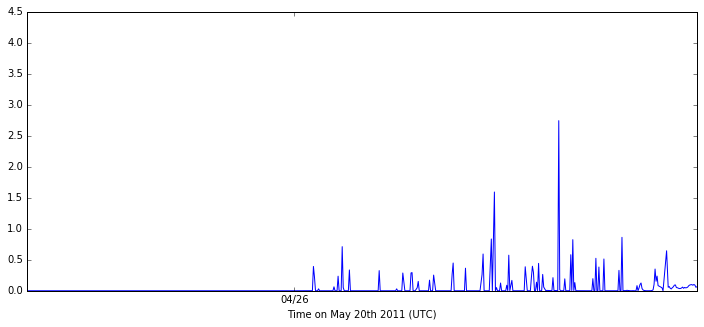

In [10]:
time1=mdates.datestr2num('20110425 0000')
time2=mdates.datestr2num('20110427 1210')

hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 4)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[12,5])
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['corrected_specific_diff_phase'])
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')



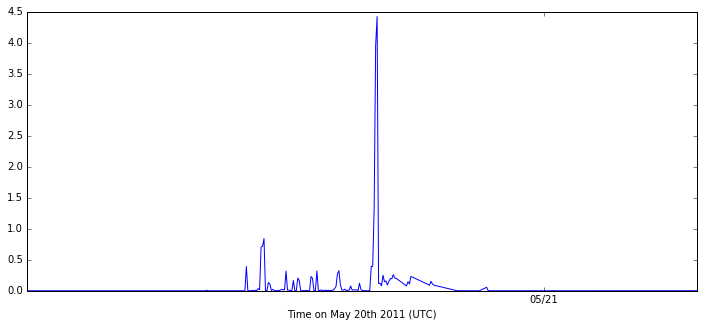

In [11]:
time1=mdates.datestr2num('20110519 0700')
time2=mdates.datestr2num('20110521 1210')

hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 4)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[12,5])
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['corrected_specific_diff_phase'])
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')



In [12]:
all_dis_files = get_file_tree(d_dir, 'sgpvdisC1*')
all_dis_files.sort()


In [13]:

distrodata = netCDF4.Dataset(all_dis_files[50], 'r')
first_distro_units = distrodata.variables['time'].units
d_time = netCDF4.num2date(distrodata.variables['time'][:],
                    first_distro_units)
rwc = distrodata.variables['liquid_water_content'][:]
print(distrodata.variables['liquid_water_content'].units)
distrodata.close()
date_time_list = d_time
rwc_list = rwc
    
for dfile in all_dis_files[51:100]:
    distrodata = netCDF4.Dataset(dfile, 'r')
    d_time = netCDF4.num2date(distrodata.variables['time'][:],
                        distrodata.variables['time'].units)
    rwc = distrodata.variables['liquid_water_content'][:]
    distrodata.close()
    #print(d_time.shape)
    date_time_list = np.concatenate((date_time_list, d_time))
    rwc_list = np.concatenate((rwc_list, rwc))
    

mm^3/m^3


In [14]:
print(len(date_time_list), len(rwc_list))

72000 72000


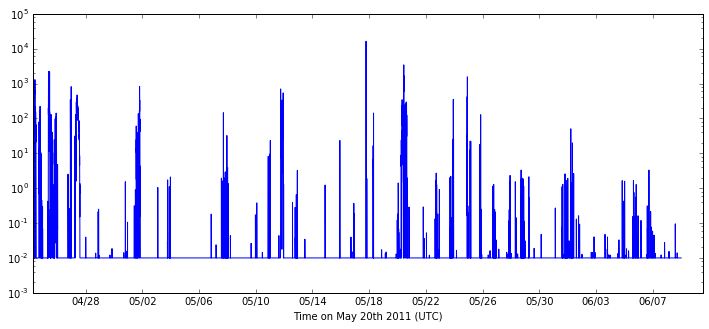

In [15]:
time1=mdates.datestr2num('20110424 0700')
time2=mdates.datestr2num('20110610 1210')

hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 4)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[12,5])
plt.semilogy(mdates.date2num(date_time_list),
         rwc_list+ 0.01)
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')


In [95]:
all_tmat_files = get_file_tree(d_dir, '*procc*')
all_tmat_files.sort()
#print(all_tmat_files)

print(all_tmat_files[0])
print(all_dis_files[50])

with open(all_tmat_files[0], 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    myp = u.load()

tmat_kdp = np.array([entry[2] for entry in myp])
tmat_z = np.array([entry[0] for entry in myp])
tmat_zdr = np.array([entry[1] for entry in myp])
tmat_a = np.array([entry[3] for entry in myp])

j = 1
for tfile in all_tmat_files[1::]:
    print(tfile)
    print(all_dis_files[50 + j])
    j = j +1
    with open(tfile, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        myp = u.load()
    
    tmat_kdp = np.concatenate((tmat_kdp, np.array([entry[2] for entry in myp])))
    tmat_z = np.concatenate((tmat_z, np.array([entry[0] for entry in myp])))
    tmat_zdr = np.concatenate((tmat_zdr, np.array([entry[1] for entry in myp])))
    tmat_a = np.concatenate((tmat_a, np.array([entry[3] for entry in myp])))
    


/data/agu2016/dis/20110420proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110420.000000.cdf
/data/agu2016/dis/20110421proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110421.000000.cdf
/data/agu2016/dis/20110422proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110422.000000.cdf
/data/agu2016/dis/20110423proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110423.000000.cdf
/data/agu2016/dis/20110424proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110424.000000.cdf
/data/agu2016/dis/20110425proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110425.000000.cdf
/data/agu2016/dis/20110426proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110426.000000.cdf
/data/agu2016/dis/20110427proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110427.000000.cdf
/data/agu2016/dis/20110428proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110428.000000.cdf
/data/agu2016/dis/20110429proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110429.000000.cdf
/data/agu2016/dis/20110430proccessed.pc
/data/agu2016/dis/sgpvdisC1.b1.20110430.000000.cdf

In [17]:
print(all_dis_files[99])
print(len(date_time_list))
print(len(tmat_kdp))

/data/agu2016/dis/sgpvdisC1.b1.20110608.000000.cdf
72000
72000


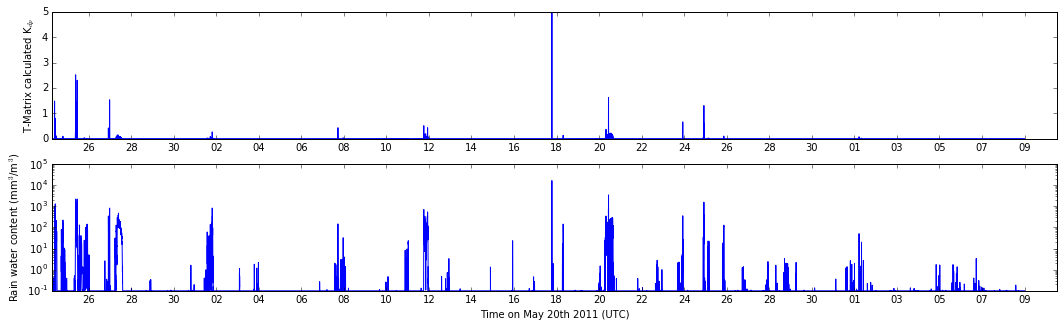

In [18]:
n_mats = len(tmat_kdp)
time1=mdates.datestr2num('20110424 0700')
time2=mdates.datestr2num('20110610 1210')
hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 2)
tFmt = mdates.DateFormatter('%d')
f = plt.figure(figsize=[18,5])
plt.subplot(2,1,1)

plt.plot(mdates.date2num(date_time_list[0:n_mats]),
         tmat_kdp)
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
#plt.xlabel('Time on May 20th 2011 (UTC)')
plt.ylim([0,5])
plt.ylabel(r'T-Matrix calculated K$_{dp}$')
plt.subplot(2,1,2)

plt.semilogy(mdates.date2num(date_time_list),
         rwc_list+0.1)
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')
plt.ylabel(r'Rain water content (mm$^3$/m$^3$)')



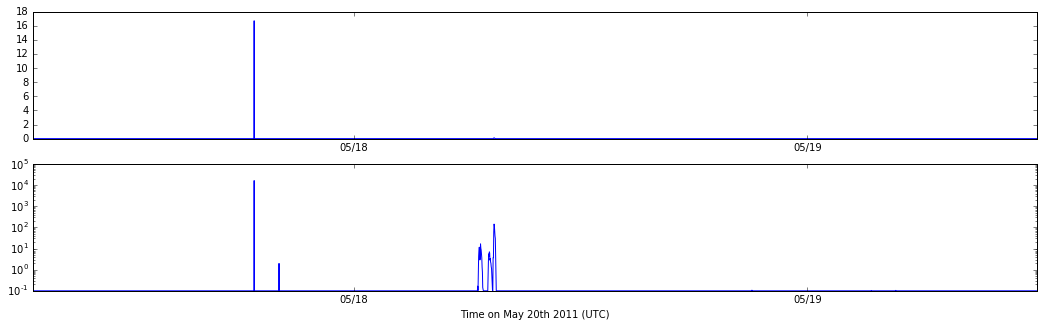

In [19]:
n_mats = len(tmat_kdp)
time1=mdates.datestr2num('20110517 0700')
time2=mdates.datestr2num('20110519 1210')
hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 1)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[18,5])
plt.subplot(2,1,1)

plt.plot(mdates.date2num(date_time_list),
         tmat_kdp)
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
#plt.xlabel('Time on May 20th 2011 (UTC)')

plt.subplot(2,1,2)

plt.semilogy(mdates.date2num(date_time_list),
         rwc_list+0.1)
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')



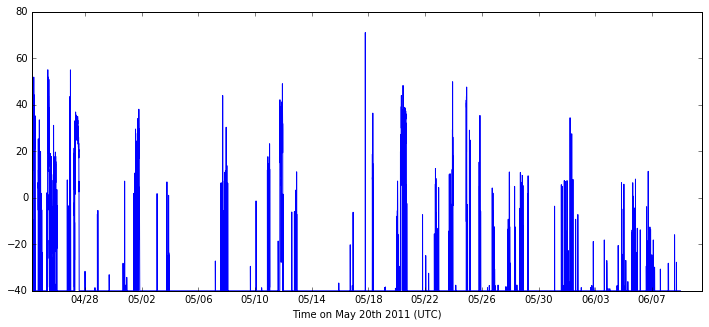

In [20]:
n_mats = len(tmat_kdp)
time1=mdates.datestr2num('20110424 0700')
time2=mdates.datestr2num('20110610 1210')

hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 4)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[12,5])
plt.plot(mdates.date2num(date_time_list),
         10.0*np.log10(tmat_z +0.0001))
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')


In [21]:
print(first_distro_units)

seconds since 2011-04-20 00:00:00 0:00


In [114]:
n_mats = len(tmat_kdp)
dist_time_since_first_dist = netCDF4.date2num(date_time_list, 
                                              first_distro_units)
radar_time_since_first_dist = netCDF4.date2num(distrometric_history['radar_start'],
                                              first_distro_units)

KDP_interpolator = interpolate.interp1d(dist_time_since_first_dist, tmat_kdp,
                                        bounds_error=False, fill_value=-9999.0,
                                       kind = 'nearest')

z_interpolator = interpolate.interp1d(dist_time_since_first_dist, tmat_z,
                                        bounds_error=False, fill_value=-9999.0,
                                       kind = 'nearest')

rwc_interpolator = interpolate.interp1d(dist_time_since_first_dist, rwc_list,
                                        bounds_error=False, fill_value=-9999.0,
                                       kind = 'nearest')

T_matrix_kdp_on_radar_points = KDP_interpolator(radar_time_since_first_dist)
T_matrix_z_on_radar_points = z_interpolator(radar_time_since_first_dist)
rwx_on_radar_points = rwc_interpolator(radar_time_since_first_dist)


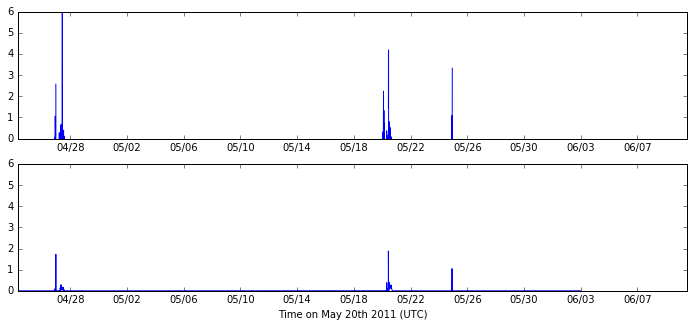

In [80]:
time1=mdates.datestr2num('20110424 0700')
time2=mdates.datestr2num('20110610 1210')

hours = mdates.HourLocator()
days = mdates.DayLocator(interval = 4)
tFmt = mdates.DateFormatter('%m/%d')
f = plt.figure(figsize=[12,5])
plt.subplot(2,1,1)
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['bringi_specific_diff_phase'])
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.ylim([0,6])
plt.subplot(2,1,2)
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         T_matrix_kdp_on_radar_points*2.0)
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.ylim([0,6])
plt.xlabel('Time on May 20th 2011 (UTC)')



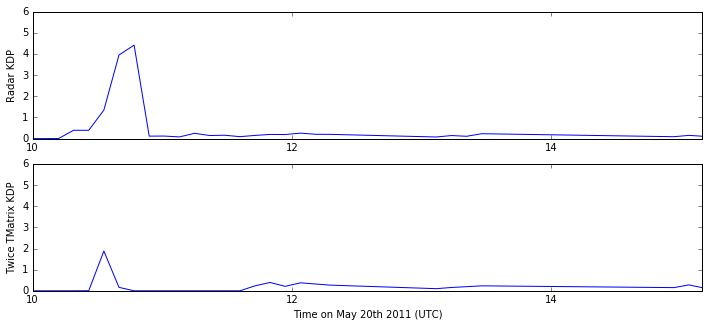

In [81]:
time1=mdates.datestr2num('20110520 1000')
time2=mdates.datestr2num('20110520 1510')

hours = mdates.HourLocator()
days = mdates.HourLocator(interval = 2)
tFmt = mdates.DateFormatter('%H')
f = plt.figure(figsize=[12,5])
plt.subplot(2,1,1)
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['corrected_specific_diff_phase'])
ax = plt.gca()
plt.ylabel('Radar KDP')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.ylim([0,6])
plt.subplot(2,1,2)
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         T_matrix_kdp_on_radar_points*2)
ax = plt.gca()
plt.ylabel('Twice TMatrix KDP')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.ylim([0,6])
plt.xlabel('Time on May 20th 2011 (UTC)')



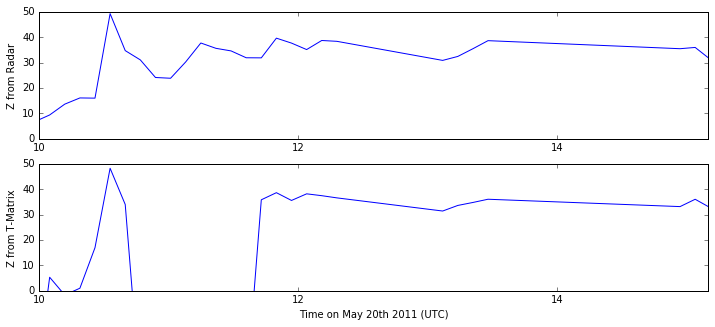

In [82]:
time1=mdates.datestr2num('20110520 1000')
time2=mdates.datestr2num('20110520 1510')

hours = mdates.HourLocator()
days = mdates.HourLocator(interval = 2)
tFmt = mdates.DateFormatter('%H')
f = plt.figure(figsize=[12,5])
plt.subplot(2,1,1)
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['reflectivity'])
ax = plt.gca()
plt.ylabel('Z from Radar')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.ylim([0,50])
plt.subplot(2,1,2)
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         10.0*np.log10(T_matrix_z_on_radar_points+0.0001))
ax = plt.gca()
plt.ylabel('Z from T-Matrix')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.ylim([0,50])
plt.xlabel('Time on May 20th 2011 (UTC)')



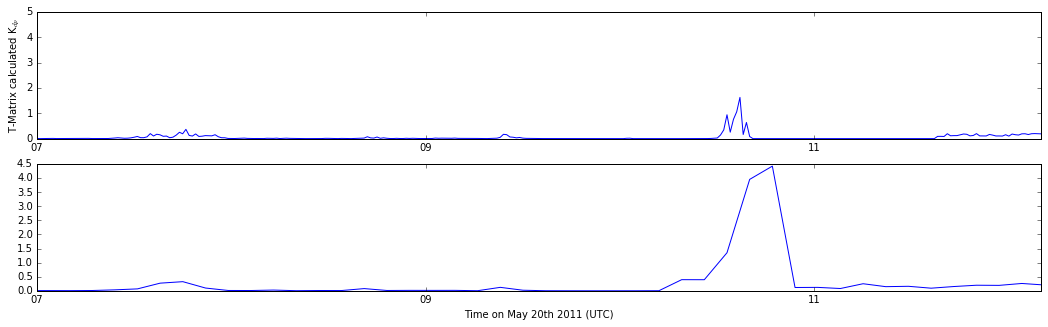

In [83]:
n_mats = len(tmat_kdp)
time1=mdates.datestr2num('20110520 0700')
time2=mdates.datestr2num('20110520 1210')
hours = mdates.HourLocator()
days = mdates.HourLocator(interval = 2)
tFmt = mdates.DateFormatter('%H')
f = plt.figure(figsize=[18,5])
plt.subplot(2,1,1)

plt.plot(mdates.date2num(date_time_list[0:n_mats]),
         tmat_kdp)
ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
#plt.xlabel('Time on May 20th 2011 (UTC)')
plt.ylim([0,5])
plt.ylabel(r'T-Matrix calculated K$_{dp}$')
plt.subplot(2,1,2)
plt.plot(mdates.date2num(distrometric_history['radar_start']),
         distrometric_history['corrected_specific_diff_phase'])

ax = plt.gca()
#plt.ylabel('Drop volume Density $\mathrm{(m^{-3})}$')
ax.xaxis_date()
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(tFmt)
ax.set_xlim([time1, time2])
plt.xlabel('Time on May 20th 2011 (UTC)')
#plt.ylabel(r'Rain water content (mm$^3$/m$^3$)')



In [124]:
is_good = np.where(rwx_on_radar_points > 0.01)

(0, 4)

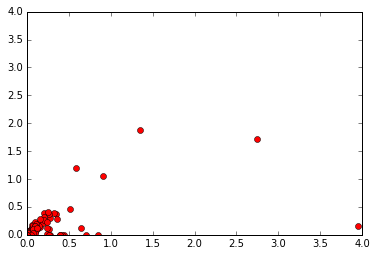

In [125]:
plt.plot(distrometric_history['corrected_specific_diff_phase'][is_good], 
         T_matrix_kdp_on_radar_points[is_good]*2.0, 'ro')
plt.ylim([0,4])
plt.xlim([0,4])

(0, 1)

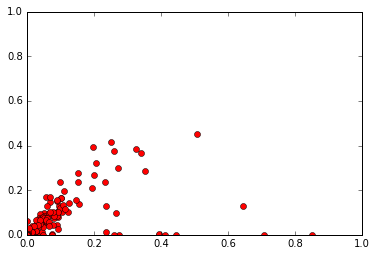

In [126]:
plt.plot(distrometric_history['corrected_specific_diff_phase'][is_good], 
         T_matrix_kdp_on_radar_points[is_good]*2.0, 'ro')
plt.ylim([0,1])
plt.xlim([0,1])

(0, 4)

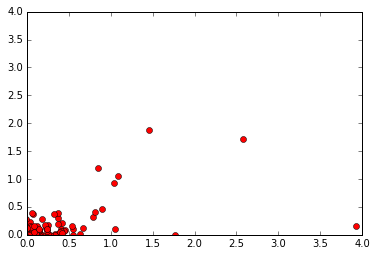

In [127]:
plt.plot(distrometric_history['bringi_specific_diff_phase'][is_good], 
         T_matrix_kdp_on_radar_points[is_good]*2.0, 'ro')
plt.ylim([0,4])
plt.xlim([0,4])

(0, 1)

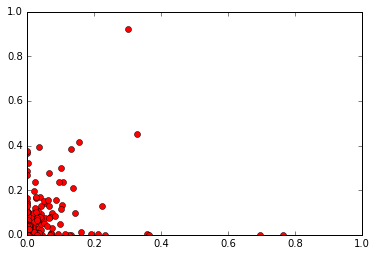

In [128]:
plt.plot(distrometric_history['maesaka_differential_phase'][is_good], 
         T_matrix_kdp_on_radar_points[is_good]*2.0, 'ro')
plt.ylim([0,1])
plt.xlim([0,1])

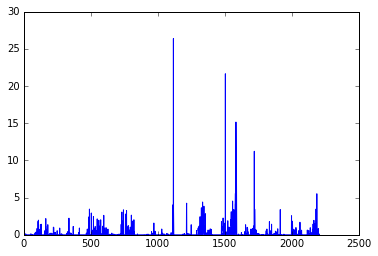

In [129]:
plt.plot(distrometric_history['maesaka_differential_phase'])

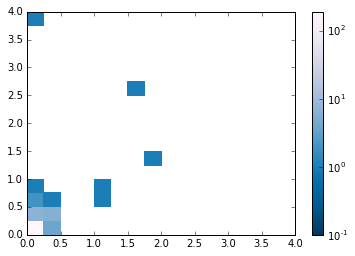

In [130]:
kdp_bins = np.linspace(0,4,17)
H, xe, ye = np.histogram2d(distrometric_history['corrected_specific_diff_phase'][is_good], 
         T_matrix_kdp_on_radar_points[is_good]*2.0, bins=(16, 16), range=([0,4], [0,4]))
plt.pcolormesh(xe, ye, H, norm=LogNorm(vmin=0.1, vmax=H.max()), cmap='PuBu_r')
plt.colorbar()

In [131]:
print(len(distrometric_history['corrected_specific_diff_phase'][is_good]))

218


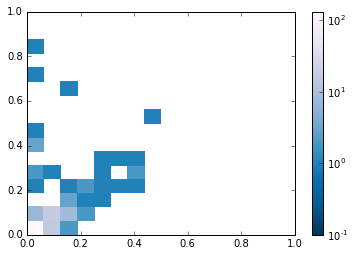

In [133]:
kdp_bins = np.linspace(0,4,17)
H, xe, ye = np.histogram2d(distrometric_history['corrected_specific_diff_phase'][is_good], 
         T_matrix_kdp_on_radar_points[is_good]*2.0, bins=(16, 16), range=([0,1], [0,1]))
plt.pcolormesh(xe, ye, H, norm=LogNorm(vmin=0.1, vmax=H.max()), cmap='PuBu_r')
plt.colorbar()